In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

df = pd.read_csv("input.csv")
df["row_id"] = df.index

url_df = pd.melt(df, id_vars=["row_id"], value_vars=["Left", "Right", "Center"],
                 var_name="leaning", value_name="url")

stop_map = {"Left": "LeftStop", "Right": "RightStop", "Center": "CenterStop"}
start_map = {"Left": "LeftStart", "Right": "RightStart", "Center": "CenterStart"}


url_df["stop_phrase"] = url_df.apply(
    lambda row: df.loc[row["row_id"], stop_map[row["leaning"]]]
    if stop_map[row["leaning"]] in df.columns else None,
    axis=1
)

url_df["start_phrase"] = url_df.apply(
    lambda row: df.loc[row["row_id"], start_map[row["leaning"]]]
    if start_map[row["leaning"]] in df.columns else None,
    axis=1
)

url_df.dropna(subset=["url"], inplace=True)


headers = {"User-Agent": "Mozilla/5.0"}
data = []

for _, row in url_df.iterrows():
    url = row["url"]
    start_phrase = row["start_phrase"]
    stop_phrase = row["stop_phrase"]
    leaning = row["leaning"]

    response = requests.get(url, headers=headers)
    response.raise_for_status()

    soup = BeautifulSoup(response.text, 'html.parser')
    title = soup.find('h1').get_text(strip=True) if soup.find('h1') else "No title"
    title = title.replace(',', '')

    for a in soup.find_all('a'):
        a.insert_before(' ')
        a.insert_after(' ')

    if isinstance(start_phrase, str) and start_phrase.strip():
        for p in soup.find_all('p'):
            text = p.get_text()
            if isinstance(start_phrase, str) and start_phrase.strip() and start_phrase in text:
                p.extract()
                break
            else:
                p.extract()

    paragraphs = []
    for p in soup.find_all('p'):
        text = p.get_text()
        if isinstance(stop_phrase, str) and stop_phrase.strip() and stop_phrase in text:
            break
        paragraphs.append(text)

    content = "\n".join(paragraphs)
    content = content.replace(',', '')

    data.append({
        "url": url,
        "leaning": leaning,
        "title": title,
        "content": content
    })


result_df = pd.DataFrame(data)
result_df.to_csv("articles_scraped.csv", index=False)


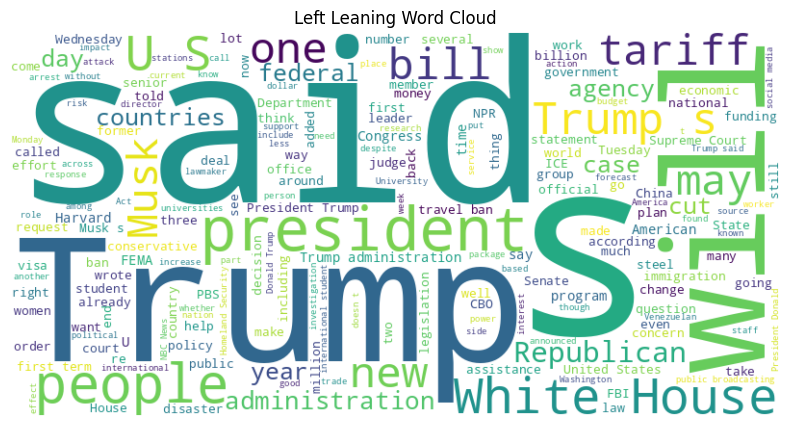

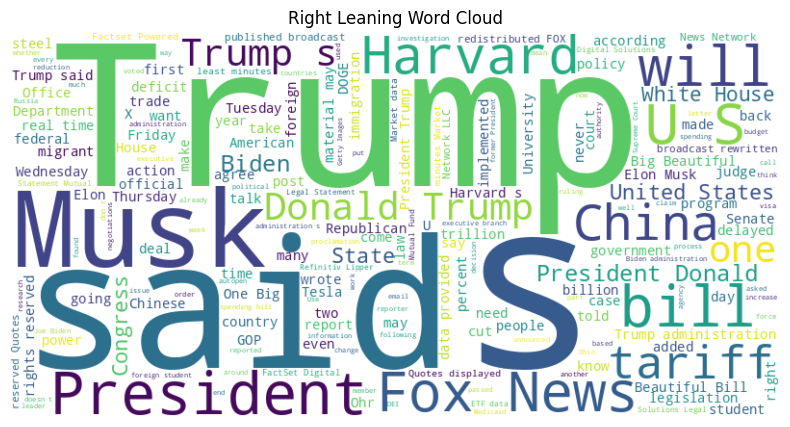

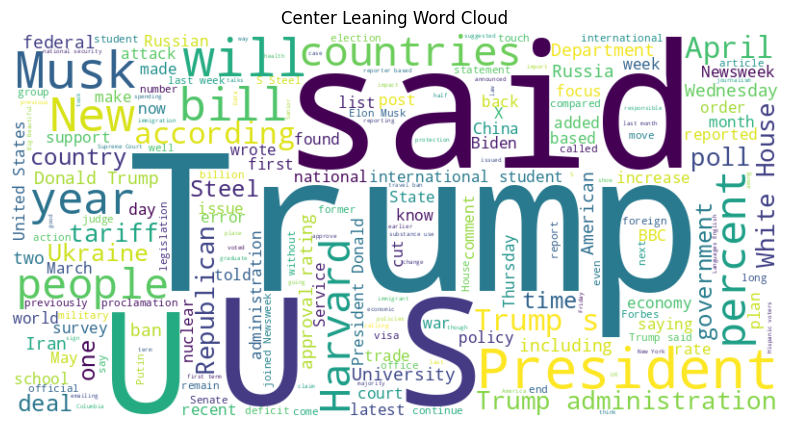

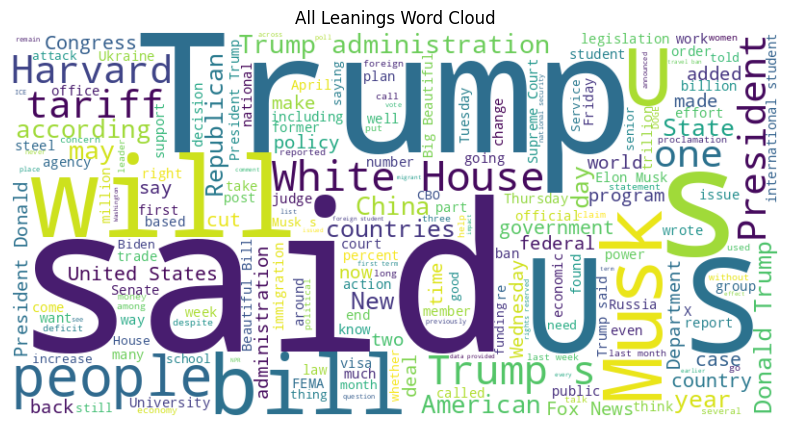

In [4]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

result_df = pd.read_csv("articles_scraped.csv")

def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

left_content = " ".join(result_df[result_df['leaning'] == 'Left']['content'].astype(str))
right_content = " ".join(result_df[result_df['leaning'] == 'Right']['content'].astype(str))
center_content = " ".join(result_df[result_df['leaning'] == 'Center']['content'].astype(str))
all_content = " ".join(result_df['content'].astype(str))

generate_wordcloud(left_content, "Left Leaning Word Cloud")
generate_wordcloud(right_content, "Right Leaning Word Cloud")
generate_wordcloud(center_content, "Center Leaning Word Cloud")
generate_wordcloud(all_content, "All Leanings Word Cloud")

#Word Cloud
We created 4 word clouds; One for each leaning, and one that includes the words from all 3 leanings. We used this word cloud in order to see which words were commonly used across all 3 sides so we could remove them to make our classifiers more accurate.

We can see some common threads appear due to the subjects of the articles, such as Harvard, which was in the news recently due to the budget cuts. Seeing words that have similar frequency across all 3 leanings, such as "Harvard", means that we needed to cut them in order to gain better accuracy.

Some were obvious that we had to remove, such as Trump as well as common words like "will" and "said". Others were interesting to see, like the phrase "Fox News" in the right-leaning word cloud - although they could be explain, such as Fox News having a high tendency to reference themselves in their own articles.

Interestingly, looking at the word clouds, there aren't any words that create a clear distinction in their use from the political leanings that aren't due to one news outlet alone or another. Some that appear more frequently in some leanings, such as "China" on the right side, could be explained to be due to the data we have just not including many left-leaning articles addressing China.